# Analysis of clusters (B.subtilis - minimal media)

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing
### Read data

In [3]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


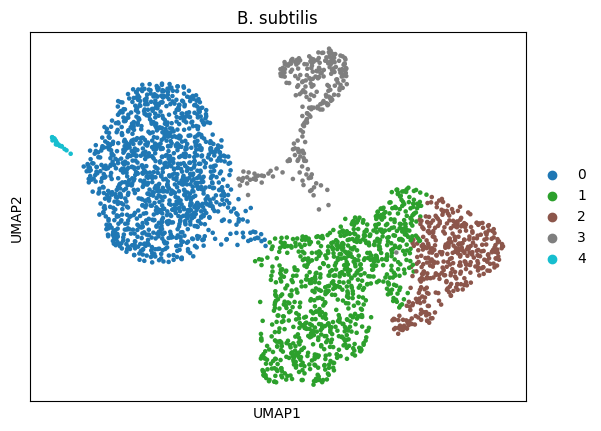

In [34]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="B. subtilis")
plt.show()

In [35]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std,Locus tag,Protein accession,Name,Symbol
index,,,,,,,,,,,,,,,,,,,,,
Sr1,Gene Expression,PA01,30,0.012931,0.012848,98.922414,36.0,3.610918,30,0.017074,...,-0.029584,-4.586321,0.095632,0.101964,-4.293682,0.473112,NaN,NaN,NaN,NaN
aadK,Gene Expression,PA01,163,0.065733,0.063663,94.145115,183.0,5.214936,163,0.077217,...,1.805381,NaN,NaN,NaN,-2.245714,0.625123,BSU_26790,NP_390556.1,aminoglycoside 6-adenylyltransferase,aadK
aag,Gene Expression,PA01,15,0.006106,0.006088,99.461207,17.0,2.890372,15,0.007506,...,-0.052299,-7.060510,0.780658,0.069086,-4.994343,0.371819,BSU_38620,NP_391741.1,3-alkylated purines and hypoxanthine DNA glyco...,aag
aapA,Gene Expression,PA01,273,0.108118,0.102663,90.193966,301.0,5.710427,273,0.117262,...,2.313870,-6.187090,1.560799,0.020054,-1.395484,0.528697,BSU_27090,NP_390587.2,small amino acid permease,aapA
abbA,Gene Expression,PA01,308,0.133980,0.125733,88.936782,373.0,5.924256,308,0.173501,...,2.437001,NaN,NaN,NaN,-1.124802,0.462729,BSU_14120,NP_389295.1,regulator of AbrB repressor,abbA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,106,0.042026,0.041167,96.192529,117.0,4.770685,106,0.048162,...,1.190302,NaN,NaN,NaN,-2.879180,0.605192,BSU_02870,NP_388169.1,high affinity Zn(II) ABC transporter (permease),znuB
znuC,Gene Expression,PA01,33,0.013649,0.013557,98.814655,38.0,3.663562,33,0.017773,...,-0.040122,-8.111126,1.504564,0.069545,-4.231052,0.458007,BSU_02860,NP_388168.1,Zn(II) transporter (ATP-binding protein),znuC
zosA,Gene Expression,PA01,36,0.015805,0.015681,98.706897,44.0,3.806662,36,0.022020,...,-0.036790,-1.751490,-0.975499,0.106674,-4.102461,0.514669,NaN,NaN,NaN,NaN


## Gene-gene correlation

In [37]:
gff = pd.read_csv("../../data/probe_Bac_scRNAseq_Rosenthal/B_subtilis_168_feature_table.tsv", sep="\t")
chrom_length = gff.iloc[-1, :]['End']
print(chrom_length)

gff = gff[['Chromosome', 'Begin', 'End', 'Orientation', 'Name', 'Locus tag', 'Symbol']]
gff.reset_index(inplace=True)

# Set the starting position of each gene (depending on strand)
def set_coord(x):
    if x['Orientation'] == 'plus':
        return x['Begin']
    elif x['Orientation'] == 'minus':
        return x['End']
    else:
        raise ValueError('Strand should not be ' + x['Orientation'])

gff['coord'] = gff.apply(set_coord, axis=1)
gff.index = gff['Locus tag']

# Start of the replication origin - Taken directly from the genbank annotation
origin_start = 410
origin_end = 1715
origin_midpoint = np.floor((origin_start + origin_end) / 2) # The +1 gives the origin an integer value
print(origin_midpoint)

gff.index = gff["Symbol"]

# Reset the start coordinate so that the origin is at zero, then sort the GFF by this value
gff = gff.loc[pd.Series(data_gene.var_names[data_gene.var_names.isin(gff.index)]),:]
gff['coord'] = (gff['coord'] - origin_midpoint) % chrom_length
gff = gff.sort_values('coord')

gff.head()

4215389
1062.0


,index,Chromosome,Begin,End,Orientation,Name,Locus tag,Symbol,coord
Symbol,,,,,,,,,
dnaN,1,NaN,1939,3075,plus,DNA polymerase III (beta subunit),BSU_00020,dnaN,877.0
recF,3,NaN,3437,4549,plus,"RecA filament-DNA complex stabilisation, ssDNA...",BSU_00040,recF,2375.0
remB,4,NaN,4567,4812,plus,regulator of extracellular matrix formation,BSU_00050,remB,3505.0
gyrB,5,NaN,4867,6783,plus,DNA gyrase (subunit B),BSU_00060,gyrB,3805.0
gyrA,6,NaN,6994,9459,plus,DNA gyrase (subunit A),BSU_00070,gyrA,5932.0


In [39]:
cor_raw = spearmanr(data_gene.layers["counts"].toarray())
cor_raw = pd.DataFrame(cor_raw.statistic, index=data_gene.var_names, columns=data_gene.var_names)
cor_raw

index,Sr1,aadK,aag,aapA,abbA,abf2,abfA,abh,abn2,abnA,...,yydJ,yydK,yyxA,zapA,znuA,znuB,znuC,zosA,zur,zwf
index,,,,,,,,,,,,,,,,,,,,,
Sr1,1.000000,-0.011335,-0.007682,0.034928,-0.001530,-0.013970,-0.016137,-0.008419,0.019325,0.032762,...,-0.007186,-0.009935,-0.009334,-0.005603,-0.020661,0.016458,-0.011431,-0.011946,-0.016264,-0.006096
aadK,-0.011335,1.000000,-0.018351,-0.000448,-0.009197,-0.021844,0.002848,-0.001159,-0.000902,-0.005089,...,0.024978,0.008440,0.002329,0.043399,-0.009212,0.013672,0.001714,-0.028538,-0.018895,0.010121
aag,-0.007682,-0.018351,1.000000,-0.007937,0.037084,-0.009851,-0.011380,-0.005937,-0.008305,-0.010830,...,-0.006147,0.045362,-0.017438,-0.003951,-0.014570,-0.014642,-0.008061,-0.008424,0.020725,-0.004423
aapA,0.034928,-0.000448,-0.007937,1.000000,0.011669,0.010300,0.045540,0.003236,-0.037187,0.001220,...,0.069519,0.031902,0.021068,0.004642,0.029262,-0.002495,-0.014035,-0.006056,0.005915,0.083145
abbA,-0.001530,-0.009197,0.037084,0.011669,1.000000,-0.021632,-0.017360,0.029346,0.020671,0.010515,...,0.017407,0.004693,0.007794,0.004345,0.027492,0.054901,0.025786,-0.020519,0.035101,0.118057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,0.016458,0.013672,-0.014642,-0.002495,0.054901,0.016706,0.006353,0.007267,0.011048,0.022822,...,0.008860,-0.018937,0.019663,0.059166,0.019193,1.000000,0.065769,-0.006265,0.005823,0.027319
znuC,-0.011431,0.001714,-0.008061,-0.014035,0.025786,0.010480,-0.016934,-0.008835,0.047025,-0.016115,...,0.025453,-0.010426,0.019119,-0.005880,-0.004374,0.065769,1.000000,-0.012536,0.004694,-0.014872
zosA,-0.011946,-0.028538,-0.008424,-0.006056,-0.020519,0.033157,0.003554,0.030321,-0.012915,0.005138,...,0.000702,0.022674,-0.013054,-0.006144,0.027445,-0.006265,-0.012536,1.000000,-0.017835,-0.005414


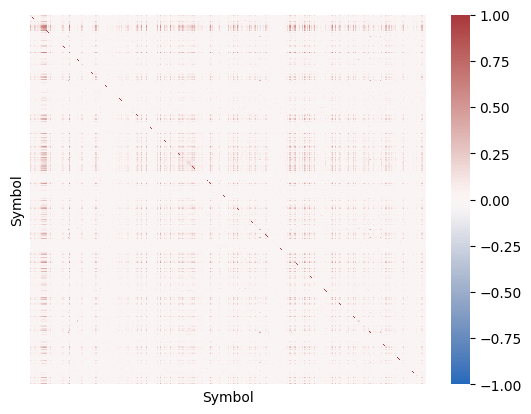

In [40]:
sns.heatmap(cor_raw.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

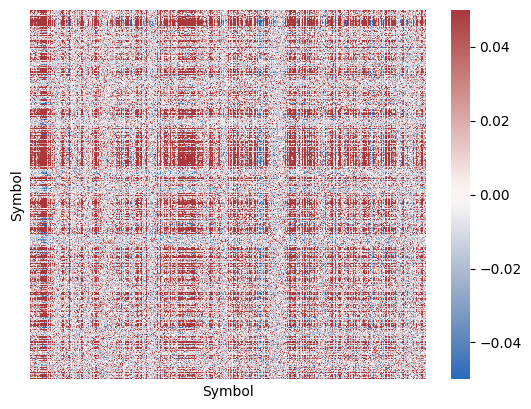

In [41]:
sns.heatmap(cor_raw.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)
plt.show()

In [44]:
cor_vst = spearmanr(data_gene.X)
cor_vst = pd.DataFrame(cor_vst.statistic, index=data_gene.var_names, columns=data_gene.var_names)

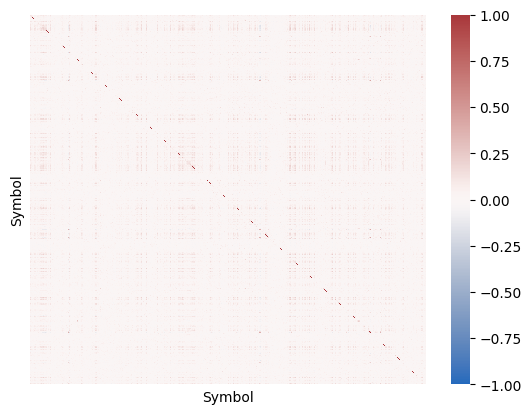

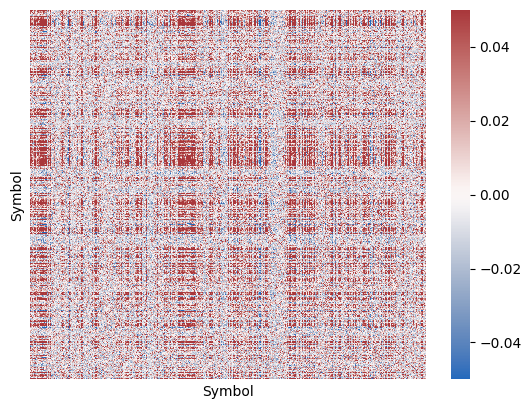

In [45]:
sns.heatmap(cor_vst.loc[gff.index, gff.index],
            cmap='vlag', vmin=-1, vmax=1, center=0,
            xticklabels=False, yticklabels=False)
plt.show()
sns.heatmap(cor_vst.loc[gff.index, gff.index],
            cmap='vlag', vmin=-0.05, vmax=0.05, center=0,
            xticklabels=False, yticklabels=False)
plt.show()